# C.008
In this notebook you will process a file containing reanalysis data downloaded from the Copernicus Data Store (CDS) to extract a wind speed time-series to compare with historical generation data from the ENTSO-E Transparency Platform.

# Step 01: Setting up the environment
This part of the notebook install the needed Python modules and the needed system libraries.
The installed modules are:
  - `cdsapi`: to access the CDS data
  - `cfgrib`: to open the GRIB file format using `xarray`
  - `entsoe-py`: to access ENTSO-E API. This module has been limited to version 0.4.2 to avoid an issue caused by the old version of Pandas available in colab. If you use this notebook on another environment you can install the latest version


In [ ]:
!pip install cdsapi
!pip install cfgrib
!pip install entsoe-py==0.4.2
!apt-get -qq install -y libeccodes0
!pip install hvplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for cdsapi: filename=cdsapi-0.5.1-py2.py3-none-any.whl size=11699 sha256=1677ca6f2d5cbbb251f189f60363dcffb0ff33e86672ca9c259994a7bf2ca40f
  Stored in directory: /root/.cache/pip/wheels/1d/2e/3c/3746e0cd076320584d6f47b688da7b13a5d5d1a92606779ca4
Successfully built cdsapi
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 2.5 MB/s 
     |████████████████████████████████| 55 kB 3.0 MB/s 
  Created wheel for eccodes: filename=eccodes-1.4.2-py3-none-any.whl size=39817 sha256=9b0a78e1c54df0039686f584373b488cbb3d3a7f73735b085ccadc2d3911ac24
  Stored in directory: /root/.cache/pip/wheels/5a/c4/e7/37b9d4a30e03d404d4e2f9a280deea683d631f370384a7d500
  Created wheel for findlibs: filename=findlibs-0.0.2-py3-none-any.whl size=6560 sha256=079cf36459b3ab4d0bfa2ae33380a434973113d0f40202c5a678cfd7

# Step 02: Downloading C3S ERA5 data
In this part we download the reanalysis data. We show how to download the data from the CDS but actually we will use the data already downloaded (and made available on Google Drive) to skip the queuing times.

To use the CDS you must [create an account](https://cds.climate.copernicus.eu/#!/home).   

In [ ]:
url = "url: https://cds.climate.copernicus.eu/api/v2"
key = "key: PUT-HERE-YOUR-KEY"

with open('/root/.cdsapirc', 'w') as f:
    f.write('\n'.join([url, key]))

with open('/root/.cdsapirc') as f:
    print(f.read())

url: https://cds.climate.copernicus.eu/api/v2
key: PUT-HERE-YOUR-KEY


Uncomment the following code to download the data from the CDS.

In [ ]:
# import cdsapi

# c = cdsapi.Client()

# c.retrieve(
#     'reanalysis-era5-single-levels',
#     {
#         'product_type': 'reanalysis',
#         'format': 'grib',
#         'variable': [
#             '100m_u_component_of_wind', '100m_v_component_of_wind',
#         ],
#         'year': '2020',
#         'month': '02',
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29',
#         ],
#         'time': [
#             '00:00', '01:00', '02:00',
#             '03:00', '04:00', '05:00',
#             '06:00', '07:00', '08:00',
#             '09:00', '10:00', '11:00',
#             '12:00', '13:00', '14:00',
#             '15:00', '16:00', '17:00',
#             '18:00', '19:00', '20:00',
#             '21:00', '22:00', '23:00',
#         ],
#         'area': [
#             60, -5, 45,
#             15,
#         ],
#     },
#     'download.grib')

In [1]:
# downloading the files from Goole Drive
!gdown 1IZA8w5m-MYcyPmLSSE8_y2BydvigQKnL

Downloading...
From: https://drive.google.com/uc?id=1IZA8w5m-MYcyPmLSSE8_y2BydvigQKnL
To: c:\Users\matte\OneDrive\local\work\energy-climate-cookbook\download.grib

  0%|          | 0.00/14.0M [00:00<?, ?B/s]
  4%|▎         | 524k/14.0M [00:00<00:02, 5.14MB/s]
 22%|██▏       | 3.15M/14.0M [00:00<00:00, 16.2MB/s]
 37%|███▋      | 5.24M/14.0M [00:00<00:00, 16.6MB/s]
 60%|█████▉    | 8.39M/14.0M [00:00<00:00, 21.1MB/s]
 78%|███████▊  | 11.0M/14.0M [00:00<00:00, 22.7MB/s]
 97%|█████████▋| 13.6M/14.0M [00:00<00:00, 23.6MB/s]
100%|██████████| 14.0M/14.0M [00:00<00:00, 21.0MB/s]


# Step 03: opening the file with xarray
`xarray` is a powerful open-source library designed to access and manipulate multi-dimensional data. With the `cfgrib` engine, [developed by ECMWF](https://github.com/ecmwf/cfgrib), we can access GRIB data using the `ecCodes` library.

In [2]:
import xarray as xr
d = xr.open_dataset('download.grib')
d

<xarray.Dataset> Size: 28MB
Dimensions:     (time: 696, latitude: 61, longitude: 81)
Coordinates:
    number      int64 8B ...
  * time        (time) datetime64[ns] 6kB 2020-02-01 ... 2020-02-29T23:00:00
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 488B 60.0 59.75 59.5 ... 45.5 45.25 45.0
  * longitude   (longitude) float64 648B -5.0 -4.75 -4.5 ... 14.5 14.75 15.0
    valid_time  (time) datetime64[ns] 6kB ...
Data variables:
    u100        (time, latitude, longitude) float32 14MB ...
    v100        (time, latitude, longitude) float32 14MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-08-19T21:40 GRIB to CDM+CF via cfgrib-0.9.1...

We create a wind speed variable as: $\mathrm{ws100}=\sqrt{\mathrm{u100}^2 + \mathrm{v100}^2}$

In [4]:
d = d.assign({'ws100': (d['u100']**2 + d['v100']**2)**0.5})

# Step 04: Plotting the data
Visualising the data is always a good way to spot inconsistencies or mistakes in the data retrieval. `xarray` offers many options to visualise the data ([tutorial](https://tutorial.xarray.dev/scipy-tutorial/04_plotting_and_visualization.html)).

A static plot (in this case for the first time step).

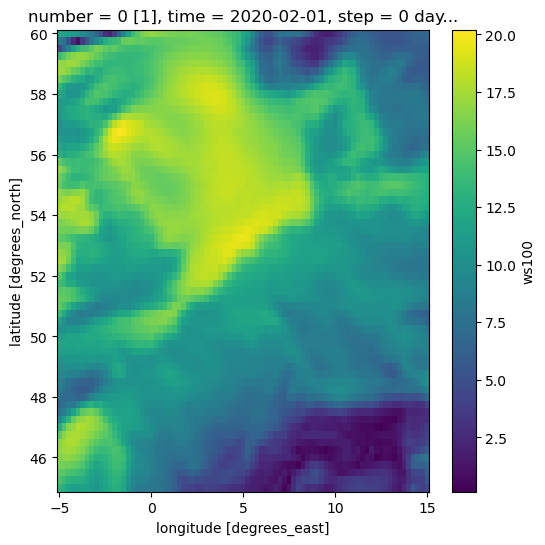

In [5]:
d.isel(time = 0)['ws100'].plot(aspect=1, size=6)

Another option is using [`HoloViews` library](https://holoviews.org/user_guide/Gridded_Datasets.html). This library gives the possibility to explore the data [interactively](https://hvplot.holoviz.org/user_guide/Interactive.html).

We use here a contour plot (`contourf`) but another option would be using a mesh ([`QuadMesh`](https://hvplot.holoviz.org/reference/xarray/quadmesh.html)).

We are not showing coast lines and using any projections because Google Colab doesn't work very well with `cartopy`. If you are working on a local environment you should be able to use the additional parameters of `contourf` or `quadmesh` to use a projection and show coastlines ([see here for a few examples](https://hvplot.holoviz.org/user_guide/Geographic_Data.html))

In [7]:
import hvplot.xarray # noqa
import hvplot as hv
import panel.widgets as pnw
import matplotlib.pyplot as plt

In [9]:
########################################################
## This code block is needed due to an issue in Google Colab in visualising holoviews plot (discussed here https://github.com/holoviz/holoviews/issues/3551)
import os
hv.extension('matplotlib')
os.environ['HV_DOC_HTML'] = 'true'
########################################################

# by default this plot would use the `long_name` attribute as label, that for `time` would be `initial time of forecast`.
# I prefer using a shorter and more general name.
d.time.attrs['long_name'] = 'time'


d['ws100'].hvplot.contourf(
    cmap='viridis',
    widget_location='top',
    levels = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30],
    width=700, aspect = 1
    )


BokehModel(combine_events=True, render_bundle={'docs_json': {'94a6a8f4-cb91-4273-ac6d-36b4d348b590': {'version…

# Step 05: Aggregate/extract

Here we perform two things:
  1. We create a time-series averaging all the grid points in a box
  2. We extract the time-series from a specific location

The extraction is quite easy with `xarray`, we select a lat/lon location (in this case the location of the [Aikengall wind farm](https://www.thewindpower.net/windfarm_en_1550_aikengall.php) in Scotland) and we select the nearest grid point.

In [10]:
sel_lat  = 55.9150047
sel_lon = -2.49688
specific_location_ts = d.sel(latitude = sel_lat, longitude = sel_lon, method = 'nearest')['ws100']

The spatial aggreation is carried out selecting a rectangular box (in this case a box [roughly centred on Scotland](http://bboxfinder.com/#56.4,-6,57.85,-1.5) and perform a mean on the spatial dimensions.

In [11]:
lon_min = -6
lon_max = -1.5
lat_min = 56.4
lat_max = 57.85

box_ts = d.sel(latitude = slice(lat_max, lat_min), longitude = slice(lon_min, lon_max)).mean(dim = ['latitude', 'longitude'])['ws100']

In [13]:
plt.rcParams['figure.figsize'] = [18, 7]
plt.plot(specific_location_ts, label = 'Specific location')
plt.plot(box_ts, label = 'Box')
plt.legend()
plt.show()

C:\Users\matte\AppData\Local\Temp\ipykernel_8572\2019888078.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


# Step 06: Downloading wind generation data
We can access wind generation data from the ENTSO-E Transparency Platform. We will download the data for the Scottish wind farm for February 2020. To use the ENTSO-E Transparency Platform's API you must [create a free account](https://transparency.entsoe.eu/usrm/user/createPublicUser), but as we did for the ERA5 data we download the data shared on Google Drive.

In [ ]:
# from entsoe import EntsoeRawClient, EntsoePandasClient
# import pandas as pd
# client = EntsoePandasClient(api_key="PUT-YOUR-ENTSOE-KEY-HERE")

# start = pd.Timestamp('20200201', tz='Europe/Brussels')
# end   = pd.Timestamp('20200229', tz='Europe/Brussels')
# # https://transparency.entsoe.eu/content/static_content/Static%20content/web%20api/Guide.html
# df = client.query_generation_per_plant('10YGB----------A', start = start, end = end, psr_type = 'B19', lookup_bzones=False)

In [14]:
# downloading the files from Goole Drive
!gdown 1opsm5QD6TSR9cICoYh9F8GlKi3umBQeM

Downloading...
From: https://drive.google.com/uc?id=1opsm5QD6TSR9cICoYh9F8GlKi3umBQeM
To: c:\Users\matte\OneDrive\local\work\energy-climate-cookbook\ENTSOE-TP-wind-20200201-20200229.parquet

  0%|          | 0.00/160k [00:00<?, ?B/s]
100%|██████████| 160k/160k [00:00<00:00, 5.13MB/s]


In [17]:
import pandas as pd
df = pd.read_parquet('ENTSOE-TP-wind-20200201-20200229.parquet')

In [18]:
sel_gen = df[(  'AKGLW-2', 'Wind Onshore')]
sel_gen = sel_gen[sel_gen.index.minute == 0]
sel_gen.head()

2020-01-31 23:00:00+00:00    0.0
2020-02-01 00:00:00+00:00    0.0
2020-02-01 01:00:00+00:00    0.0
2020-02-01 02:00:00+00:00    0.0
2020-02-01 03:00:00+00:00    0.0
Name: (AKGLW-2, Wind Onshore), dtype: float64

# Step 07: Comparing wind speed with wind power generation
We can compare the three time-series using their normalised value (using a z-score transformation)

In [19]:
import scipy.stats as stats

plt.rcParams['figure.figsize'] = [18, 7]
plt.plot(sel_gen.index, stats.zscore(sel_gen), label = 'Aikengall generation')
plt.plot(specific_location_ts['time'], stats.zscore(specific_location_ts), label = 'Specific location')
plt.plot(box_ts['time'], stats.zscore(box_ts), label = 'Box')
plt.legend()
